<h1 style = "font-size: 35px; text-align: center;">AI CA4</h1>
<h1 style = "font-size: 35px; text-align: center;">Machine Learning</h1>
<h1 style = "font-size: 32px; text-align: center; color: #666">Taha Shabani 810196491</h1>

<br>
<h1 style = "text-align: center">Prelude</h1>
<br>
<h2>Definition of project:</h2>
<p style = "font-size: 14px">The goal of this project is an introduction to machine learning (supervised learning). We will work with <mark>scikit learn</mark> library and its various classifiers like <b>KNN, Decision Tree, and Logistic</b>, then we'll try to optimize accuracy and precision by using random forest, hyperparameters tuning, and ...
<br>    
<br>
First of all, we read dataset from <mark>data.csv</mark> file, preprocess on it and calculate <mark>information gain</mark> for all features, this would be end of <b>Phase 0</b>.
<br>
<br>    
In <b>Phase 1</b> we implement 3 classifiers and evaluate their accuracy parameters and try to tune its hyperparameters to achieve better results.
<br>
<br>    
Ultimately in <b>Phase 2</b> we use <mark>bagging</mark> for KNN and Decision Tree and <mark>Random forest</mark>, and then we will show the effect of bagging on overfitting.
</p>

<br>

<h1 style= "text-align: center">Phase 0</h1>
<br>
<h3> 1. Preprocessing data: </h3>
<p>After reading data.csv file, <mark>getProcessedData()</mark> preprocesses these data and returns data and target value. Preprocessing consists of these steps: </p>
<p style="text-indent :2em;">1. <mark>Date analysis</mark>: preprocessDate() extract useful information from raw date, for instance: year, month, day, day of week, which can help us to gather better features.</p>
<p style="text-indent :2em;">2. <mark>Categorial data analysis</mark>: In order to analize categorical data, we have two main choices: <b>1. one hot encoding, 2. labeled encoding</b> which we will explain them soon. but in our project one hot encoding works a bit better (about 2 percents), but you can change one hot to labeled (input parameter of getProcessedData() ). </p>
<p style="text-indent :2em;">3. <mark>Scaling</mark>: Most of the times, our dataset will contain features highly varying in magnitudes, units and range. But importance of data is not always the same as variable range, so for some features we need to scale values (scale up or down) to supress their high or low impact and to bring all features to the same level of magnitudes or magnitudes related to their importance. Plus, we have lots of scaling algorithms for example: Standardisation, Min-Max Scaling, and Unit Vector which we used <b>Standardisation</b> for 2 columns that contains wide range of values: <b>Total Quantity and Total Price</b>.</p>

<h4 style = "color: red">One hot Encodling vs Labeled encoding</h4>
<p>
    As we mentioned, these encodings are used for categorical data, which in our case is <b>Country</b> column.
    <br>
    <br>
    <mark>One Hot</mark> adds a column for every different values in categorical column and sets the bit for current value to 1 and 0 for the rest. for example if countries are (USA, Frace, Germany) and if current country is Germany we will have (0,0,1).
    <br>
    On the other side <mark>Labeled</mark> maps every value to a numeric one, for example (USA -> 1, Frace -> 2, Germany -> 3).
    <br>
    <br>
    <b>One Hot cons</b>: As it's clear, OneHot makes the data too big and adds lots of columns, so operations might get a little slower and overfitting is probable. In these cases we use labeled encoding or some method like scaling and ...
    <br>
    <b>Labeled cons</b>: Label encoding is acceptable for discrete values but not continuous ones, plus, it could trigger some issues for classifers, for example as we said we assigned USA to 1 and Frace to 2, now Frace has a higher value with no reason, and it can be harmful for network accuracy.
    
    
</p>
<br>

In [1]:
import csv
import pandas as pd
import math
import numpy as np
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt



def preprocessDate(df)  :
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['dayOfWeek'] = df['Date'].dt.dayofweek
    
    del df['Date']
    return df

def preprocessLabeledCategorical(data, df) : 
    countries = df['Country'].tolist() 
    le = preprocessing.LabelEncoder()
    le.fit(countries)
    # print(list(le.classes_))
    transformedCountries = le.transform(countries)
    for i in range(len(data)) : 
        data[i]['Country'] = transformedCountries[i]
    
    return data

def scaleData(data):
    scalableData = []
    for row in data:
        scalableData.append([row["Total Quantity"], row["Total Price"]])
    
    scaler = StandardScaler()
    scaler.fit(scalableData)
    transformedData = scaler.transform(scalableData)
    
    for i in range(len(data)) :
        data[i]['Total Quantity'] = transformedData[i][0]
        data[i]['Total Price'] = transformedData[i][1]
    
    return data                            

def getProcessedData(dataFile, encodingType) : 
    data = []
    targetData = []
    col_list = ["Customer ID", "Total Quantity", "Total Price", "Country", "Date", "Is Back", "Purchase Count"]
    df = pd.read_csv(dataFile, usecols=col_list)
    df['Date']= pd.to_datetime(df['Date'])
    
    if (encodingType == "oneHot") :
        df = pd.concat([df,pd.get_dummies(df['Country'], prefix = "country")],axis=1).drop(['Country'],axis=1)


    
    df = preprocessDate(df)
    
    for index, dfRow in df.iterrows() : 
        if (dfRow['Is Back'] == 'Yes') : 
            dfRow['Is Back'] = 1
        else:
            dfRow['Is Back'] = 0
            
        targetData.append(dfRow['Is Back'])    
        del dfRow['Is Back']
        del dfRow['Customer ID']
        data.append(dfRow)
        
    if (encodingType == "labeled") :
        preprocessLabeledCategorical(data, df)
        
    data = scaleData(data)
    
    labels = list(df)
    labels.remove('Customer ID')
    labels.remove('Is Back')
    return [data, targetData, labels]

<br>
<h3> 2. Calculating informaition gain. </h3>
<p>Information gain represents difference between entropy before and after spliting for a feature (in decision tree) an as its bigger, its better to use first. we Used <mark>mutual_info_classif()</mark> (a provided function in scikit_learn) to measure information gains. The result is shown on a plot below.</p>

<p>In order to have a reliable information gains to work with, we eliminate <b>'Customer ID' and 'Is Back'</b> columns because 'Customer ID' is a unique field and can not help us in our classification, but it would have high gain because of its uniqueness and 'Is Back' is the target column that we want to learn so it must be in targetData not data.</p>

<p>Extraced data from date such as year, month, day of week, (maybe because in some months and holidays shopping is more reasonable than the other times). and some other features (Total price) have high gains.<p>

In [28]:
[data, targetData, labels] = getProcessedData("data.csv", "oneHot") #second parameter: "labeled" or "oneHot"

informationGains = mutual_info_classif(data, targetData)

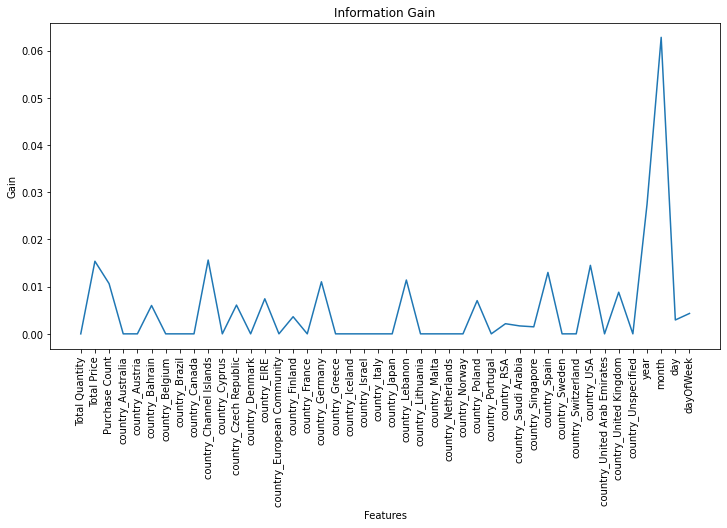

In [3]:
def showInformationGains() :
    plt.figure(figsize=(12, 6))
    plt.plot(informationGains) 
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.xlabel('Features') 
    plt.ylabel('Gain') 
    plt.title('Information Gain') 

    plt.show()
showInformationGains()

phase1: knn

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

trainData, testData, trainTarget, testTarget = train_test_split(data, targetData, test_size=0.20, random_state=30)


def classifyKnn(n = 8) : 
    knnTestPredic = []
    knnTrainPredic = []
    
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(trainData, trainTarget)
    
    knnTestPredic = neigh.predict(testData)
       
    knnTrainPredic = neigh.predict(trainData)
        
    return [knnTrainPredic, knnTestPredic]

def classifyDecisionTree(d = 4) : 
    treeTestPredic = []
    treeTrainPredic = []
    
    clf = DecisionTreeClassifier(random_state=10, max_depth=d)
    clf.fit(trainData, trainTarget)
     
    treeTestPredic = clf.predict(testData)
    
    treeTrainPredic = clf.predict(trainData)
        
    return [treeTrainPredic, treeTestPredic]
    
def classifyLogistic() : 
    logisticTestPredic = []
    logisticTrainPredic = []
    
    clf = LogisticRegression(max_iter = 10000).fit(trainData, trainTarget)
    
    
    logisticTestPredic = clf.predict(testData)
    
    logisticTrainPredic = clf.predict(trainData)
        
    return [logisticTrainPredic, logisticTestPredic]
    
knnPredictions = classifyKnn()
treePredictions = classifyDecisionTree()
logisticPredictions = classifyLogistic()

In [5]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

def showPrecisions() : 
    knnTrainPrecision = "{:.2f}".format(precision_score(trainTarget, knnPredictions[0], average = 'weighted') * 100)
    knnTestPrecision = "{:.2f}".format(precision_score(testTarget, knnPredictions[1], average = 'weighted') * 100)

    treeTrainPrecision = "{:.2f}".format(precision_score(trainTarget, treePredictions[0], average = 'weighted') * 100)
    treeTestPrecision = "{:.2f}".format(precision_score(testTarget, treePredictions[1], average = 'weighted') * 100)
    
    logisticTrainPrecision = "{:.2f}".format(precision_score(trainTarget, logisticPredictions[0], average = 'weighted') * 100)
    logisticTestPrecision = "{:.2f}".format(precision_score(testTarget, logisticPredictions[1], average = 'weighted') * 100)
    
    
    df2 = pd.DataFrame (columns = ['Precision', 'KNN', 'Decision Tree', 'Logistic'])
    df2['Precision'] = ['Train', 'Test']
    df2['KNN'] = [knnTrainPrecision, knnTestPrecision]
    df2['Decision Tree'] = [treeTrainPrecision, treeTestPrecision]
    df2['Logistic'] = [logisticTrainPrecision, logisticTestPrecision]
    
    return df2

def showAccuracy() : 
    knnTrainPrecision = "{:.2f}".format(accuracy_score(trainTarget, knnPredictions[0]) * 100)
    knnTestPrecision = "{:.2f}".format(accuracy_score(testTarget, knnPredictions[1]) * 100)

    treeTrainPrecision = "{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)
    treeTestPrecision = "{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)
    
    logisticTrainPrecision = "{:.2f}".format(accuracy_score(trainTarget, logisticPredictions[0]) * 100)
    logisticTestPrecision = "{:.2f}".format(accuracy_score(testTarget, logisticPredictions[1]) * 100)
    
    
    df2 = pd.DataFrame (columns = ['Accuracy', 'KNN', 'Decision Tree', 'Logistic'])
    df2['Accuracy'] = ['Train', 'Test']
    df2['KNN'] = [knnTrainPrecision, knnTestPrecision]
    df2['Decision Tree'] = [treeTrainPrecision, treeTestPrecision]
    df2['Logistic'] = [logisticTrainPrecision, logisticTestPrecision]
    
    return df2

def showRecall() : 
    knnTrainPrecision = "{:.2f}".format(recall_score(trainTarget, knnPredictions[0], average = 'weighted') * 100)
    knnTestPrecision = "{:.2f}".format(recall_score(testTarget, knnPredictions[1], average = 'weighted') * 100)

    treeTrainPrecision = "{:.2f}".format(recall_score(trainTarget, treePredictions[0], average = 'weighted') * 100)
    treeTestPrecision = "{:.2f}".format(recall_score(testTarget, treePredictions[1], average = 'weighted') * 100)
    
    logisticTrainPrecision = "{:.2f}".format(recall_score(trainTarget, logisticPredictions[0], average = 'weighted') * 100)
    logisticTestPrecision = "{:.2f}".format(recall_score(testTarget, logisticPredictions[1], average = 'weighted') * 100)
    
    
    df2 = pd.DataFrame (columns = ['Recall', 'KNN', 'Decision Tree', 'Logistic'])
    df2['Recall'] = ['Train', 'Test']
    df2['KNN'] = [knnTrainPrecision, knnTestPrecision]
    df2['Decision Tree'] = [treeTrainPrecision, treeTestPrecision]
    df2['Logistic'] = [logisticTrainPrecision, logisticTestPrecision]
    
    return df2

In [6]:
showPrecisions()

,Precision,KNN,Decision Tree,Logistic
0,Train,73.05,74.50,75.76
1,Test,66.92,71.19,74.07


In [7]:
showAccuracy()

,Accuracy,KNN,Decision Tree,Logistic
0,Train,74.03,75.32,68.61
1,Test,68.31,73.23,70.14


In [8]:
showRecall()

,Recall,KNN,Decision Tree,Logistic
0,Train,74.03,75.32,68.61
1,Test,68.31,73.23,70.14


In [9]:
it = 16
def showKnnAccuracyDiagram() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        knnPredictions = classifyKnn(i)
        trainPrecisions.append((float)("{:.2f}".format(accuracy_score(trainTarget, knnPredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(accuracy_score(testTarget, knnPredictions[1]) * 100)))
        
    plt.figure(figsize=(12, 10))
    
    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Neighbors') 
    plt.ylabel('Accuracy') 
    plt.title('KNN Accuracy') 
        
    plt.show()
    
def showDecisionTreeAccuracyDiagram() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = classifyDecisionTree(i)
        trainPrecisions.append((float)("{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)))
        
    plt.figure(figsize=(12, 10))
    
    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Depth') 
    plt.ylabel('Accuracy') 
    plt.title('Decision Tree Accuracy') 
        
    plt.show()

def showKnnPrecisionDiagram() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        knnPredictions = classifyKnn(i)
        trainPrecisions.append((float)("{:.2f}".format(precision_score(trainTarget, knnPredictions[0], average = 'weighted') * 100)))
        testPrecisions.append((float)("{:.2f}".format(precision_score(testTarget, knnPredictions[1], average = 'weighted') * 100)))

    plt.figure(figsize=(12, 10))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Neighbors') 
    plt.ylabel('Precision') 
    plt.title('KNN Precision') 

    plt.show()
    
def showDecisionTreePrecisionDiagram() :
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = classifyDecisionTree(i)
        trainPrecisions.append((float)("{:.2f}".format(precision_score(trainTarget, treePredictions[0], average = 'weighted') * 100)))
        testPrecisions.append((float)("{:.2f}".format(precision_score(testTarget, treePredictions[1], average = 'weighted') * 100)))
        
    plt.figure(figsize=(12, 10))
    
    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Depth') 
    plt.ylabel('Precision') 
    plt.title('Decision Tree Precision') 
        
    plt.show()

2 3 4 5 6 7 8 9 10 11 12 13 14 15 

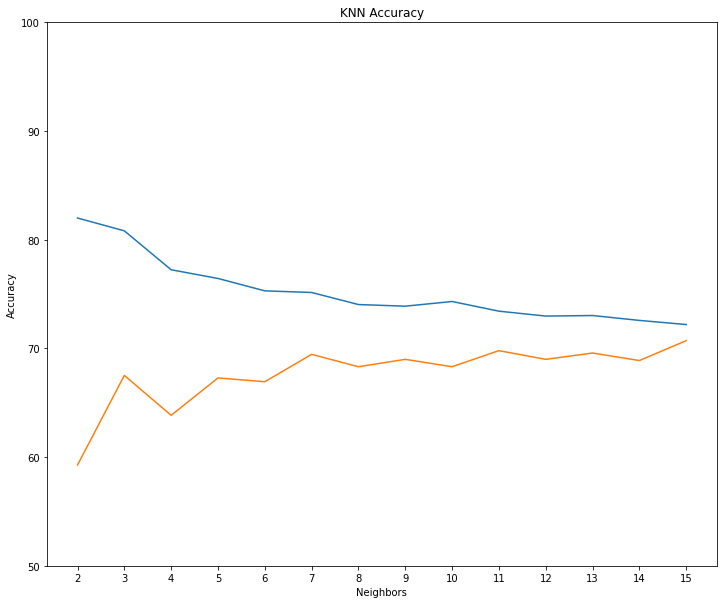

In [10]:
showKnnAccuracyDiagram()

2 3 4 5 6 7 8 9 10 11 12 13 14 15 

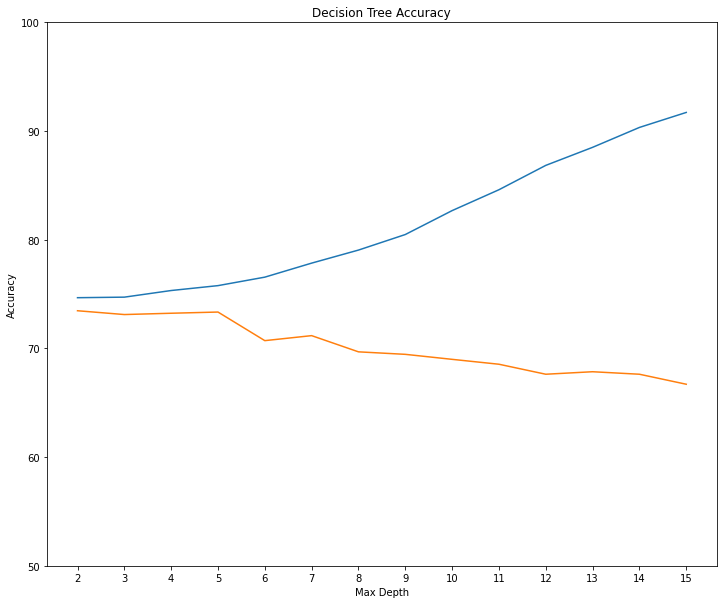

In [11]:
showDecisionTreeAccuracyDiagram()

2 3 4 5 6 7 8 9 10 11 12 13 14 15 

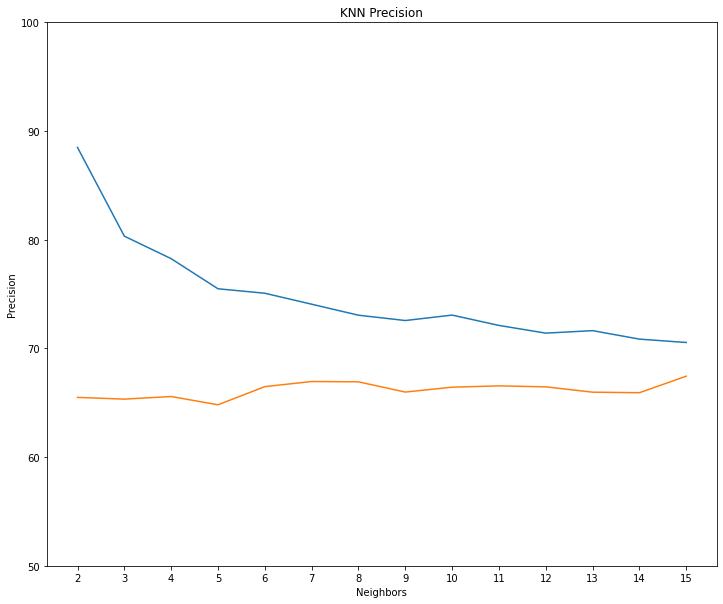

In [12]:
showKnnPrecisionDiagram()

2 3 4 5 6 7 8 9 10 11 12 13 14 15 

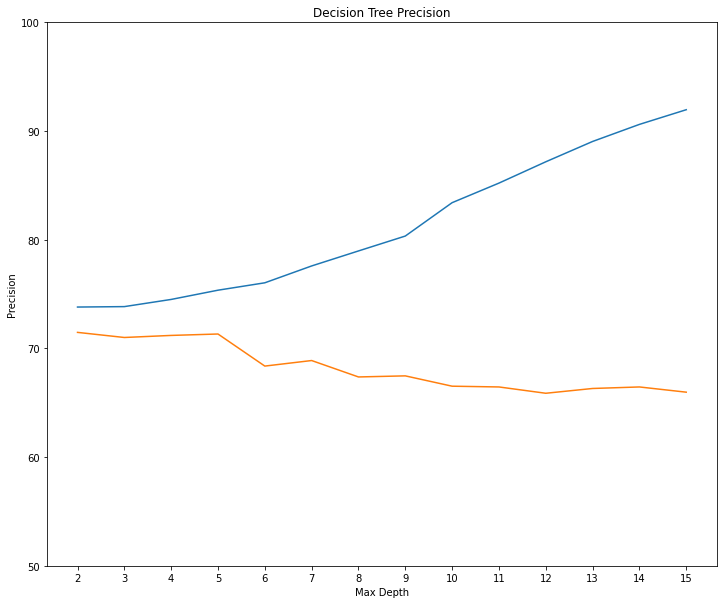

In [13]:
showDecisionTreePrecisionDiagram()

phase2

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

def evaluateKNNBagging() :
    knnTestPredic = []
    knnTrainPredic = []
    clf = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=8), 
                            max_samples = 0.5, max_features = 0.5, n_estimators=3, random_state=0).fit(trainData, trainTarget)

    knnTestPredic = clf.predict(testData)

    knnTrainPredic = clf.predict(trainData)
        
    return [knnTrainPredic, knnTestPredic]
    
knnPredictions = evaluateKNNBagging()  

def evaluateDecisionTreeBagging(d = 4) :
    TreeTestPredic = []
    TreeTrainPredic = []
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=d), 
                            max_samples = 0.5, max_features = 0.5, n_estimators=3, random_state=0).fit(trainData, trainTarget)

    TreeTestPredic = clf.predict(testData)

    TreeTrainPredic = clf.predict(trainData)
        
    return [TreeTrainPredic, TreeTestPredic]
    
knnPredictions = evaluateKNNBagging() 
treePredictions = evaluateDecisionTreeBagging()

evaluateKNNBagging()
evaluateDecisionTreeBagging()

print("In tables below, forth column: Logistic is not related to current phase, it is related to phase1")
    

In tables below, forth column: Logistic is not related to current phase, it is related to phase1


In [15]:
showPrecisions()

,Precision,KNN,Decision Tree,Logistic
0,Train,74.30,72.79,75.76
1,Test,69.25,71.15,74.07


In [16]:
showAccuracy()

,Accuracy,KNN,Decision Tree,Logistic
0,Train,75.34,74.00,68.61
1,Test,70.59,72.54,70.14


In [17]:
showRecall()

,Recall,KNN,Decision Tree,Logistic
0,Train,75.34,74.00,68.61
1,Test,70.59,72.54,70.14


In [18]:
from sklearn.ensemble import RandomForestClassifier

def evaluateRandomForest(type = "max_depth", d = 4) : 
    TreeTestPredic = []
    TreeTrainPredic = []
    
    if (type == "max_depth") : 
        clf = RandomForestClassifier(max_depth=d, random_state=0, n_estimators=3, max_features=0.5, max_samples=0.5)
    elif (type == "max_leaf") : 
        clf = RandomForestClassifier(max_depth=4, max_leaf_nodes = d, random_state=0, n_estimators=3, max_features=0.5, max_samples=0.5)
    elif (type == "max_features") : 
        clf = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=3, max_features=d, max_samples=0.5)
        
    clf.fit(trainData, trainTarget)
    
    TreeTestPredic = clf.predict(testData)

    TreeTrainPredic = clf.predict(trainData)
        
    return [TreeTrainPredic, TreeTestPredic]

def showRandomForestSpecifications(type = "max_depth", d = 4) : 
    treePredictions = evaluateRandomForest(type, d)
    
    treeTrainPrecision = "{:.2f}".format(average_precision_score(trainTarget, treePredictions[0]) * 100)
    treeTestPrecision = "{:.2f}".format(average_precision_score(testTarget, treePredictions[1]) * 100)

    treeTrainAccuracy = "{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)
    treeTestAccuracy = "{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)
    
    treeTrainRecall = "{:.2f}".format(recall_score(trainTarget, treePredictions[0], average = 'weighted') * 100)
    treeTestRecall = "{:.2f}".format(recall_score(testTarget, treePredictions[1], average = 'weighted') * 100)
    
    
    df2 = pd.DataFrame (columns = ['Random Forest', 'Precision', 'Accuracy', 'Recall'])
    
    df2['Random Forest'] = ['Train', 'Test']
    df2['Precision'] = [treeTrainPrecision, treeTestPrecision]
    df2['Accuracy'] = [treeTrainAccuracy, treeTestAccuracy]
    df2['Recall'] = [treeTrainRecall, treeTestRecall]
    
    return df2

showRandomForestSpecifications()

,Random Forest,Precision,Accuracy,Recall
0,Train,75.93,74.37,74.37
1,Test,75.68,72.08,72.08


In [19]:
it = 15
def showRFMaxDepthPrecisionRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = evaluateRandomForest("max_depth", i)
        trainPrecisions.append((float)("{:.2f}".format(average_precision_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(average_precision_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 6))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max depth') 
    plt.ylabel('Precision') 
    plt.title('Random Forest Precision') 

    plt.show() 
    
def showRFMaxDepthAccuracyRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = evaluateRandomForest("max_depth", i)
        trainPrecisions.append((float)("{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 6))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Depth') 
    plt.ylabel('Accuracy') 
    plt.title('Random Forest Accuracy') 

    plt.show()
    
def showRFMaxLeafPrecisionRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = evaluateRandomForest("max_leaf", i)
        trainPrecisions.append((float)("{:.2f}".format(average_precision_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(average_precision_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 6))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Leaf Nodes') 
    plt.ylabel('Precision') 
    plt.title('Random Forest Precision') 

    plt.show() 
    
def showRFMaxLeafAccuracyRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = evaluateRandomForest("max_leaf", i)
        trainPrecisions.append((float)("{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 6))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Leaf Nodes') 
    plt.ylabel('Accuracy') 
    plt.title('Random Forest Accuracy') 

    plt.show() 
    
def showRFMaxFeaturePrecisionRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append("{:.2f}".format(i * 100 / it))
        treePredictions = evaluateRandomForest("max_features", (float)(i / it))
        trainPrecisions.append((float)("{:.2f}".format(average_precision_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(average_precision_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 6))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Features') 
    plt.ylabel('Precision') 
    plt.title('Random Forest Precision') 

    plt.show() 
    
def showRFMaxFeatureAccuracyRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append("{:.2f}".format(i * 100 / it))
        treePredictions = evaluateRandomForest("max_features", (float)(i / it))
        trainPrecisions.append((float)("{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 6))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Features') 
    plt.ylabel('Accuracy') 
    plt.title('Random Forest Accuracy') 

    plt.show()        

2 3 4 5 6 7 8 9 10 11 12 13 14 

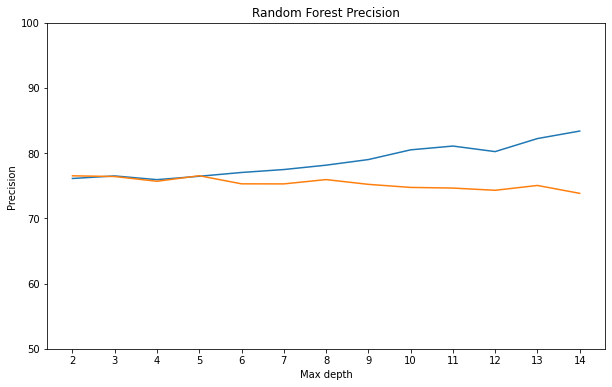

In [20]:
showRFMaxDepthPrecisionRange()

2 3 4 5 6 7 8 9 10 11 12 13 14 

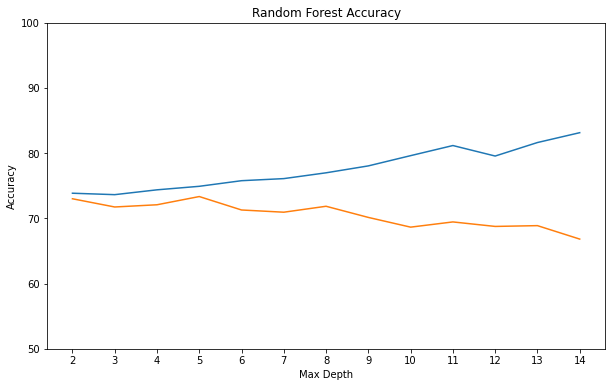

In [21]:
showRFMaxDepthAccuracyRange()

2 3 4 5 6 7 8 9 10 11 12 13 14 

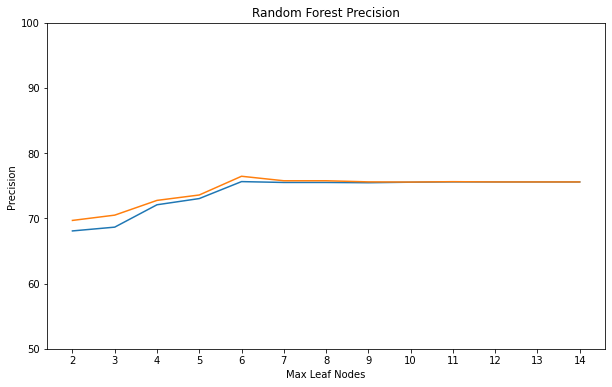

In [22]:
showRFMaxLeafPrecisionRange()

2 3 4 5 6 7 8 9 10 11 12 13 14 

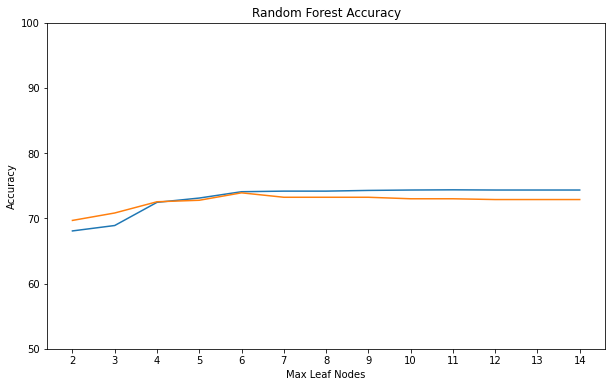

In [23]:
showRFMaxLeafAccuracyRange()

2 3 4 5 6 7 8 9 10 11 12 13 14 

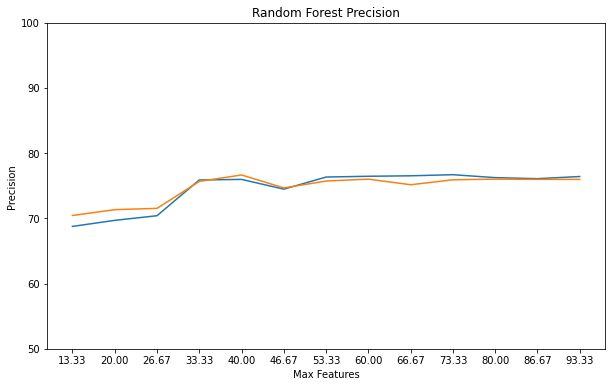

In [24]:
showRFMaxFeaturePrecisionRange()

2 3 4 5 6 7 8 9 10 11 12 13 14 

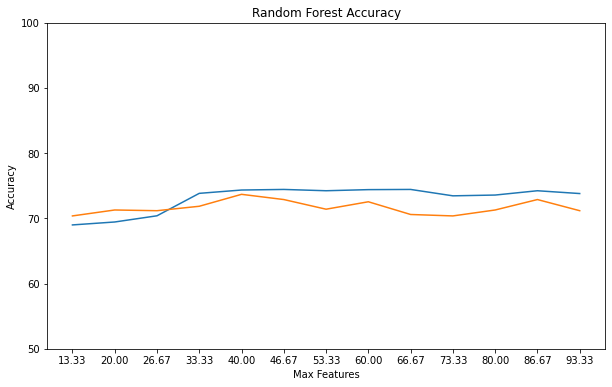

In [25]:
showRFMaxFeatureAccuracyRange()

In [26]:
def checkBaggingOnOverfitting() : 
    treePredictions = classifyDecisionTree(20)
    baggedTreePredictions = evaluateDecisionTreeBagging(20)
    
    treeTrainPrecision = "{:.2f}".format(precision_score(trainTarget, treePredictions[0], average = 'weighted') * 100)
    treeTestPrecision = "{:.2f}".format(precision_score(testTarget, treePredictions[1], average = 'weighted') * 100)

    treeTrainAccuracy = "{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)
    treeTestAccuracy = "{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)
    
    treeTrainRecall = "{:.2f}".format(recall_score(trainTarget, treePredictions[0], average = 'weighted') * 100)
    treeTestRecall = "{:.2f}".format(recall_score(testTarget, treePredictions[1], average = 'weighted') * 100)
    
    
    bTreeTrainPrecision = "{:.2f}".format(precision_score(trainTarget, baggedTreePredictions[0], average = 'weighted') * 100)
    bTreeTestPrecision = "{:.2f}".format(precision_score(testTarget, baggedTreePredictions[1], average = 'weighted') * 100)

    bTreeTrainAccuracy = "{:.2f}".format(accuracy_score(trainTarget, baggedTreePredictions[0]) * 100)
    bTreeTestAccuracy = "{:.2f}".format(accuracy_score(testTarget, baggedTreePredictions[1]) * 100)
    
    bTreeTrainRecall = "{:.2f}".format(recall_score(trainTarget, baggedTreePredictions[0], average = 'weighted') * 100)
    bTreeTestRecall = "{:.2f}".format(recall_score(testTarget, baggedTreePredictions[1], average = 'weighted') * 100)
    
    
    df2 = pd.DataFrame (columns = [' ', 'Precision', 'Accuracy', 'Recall'])
    
    df2[' '] = ['Normal Train', 'Normal Test', 'Bagging Train', 'Bagging Test']
    df2['Precision'] = [treeTrainPrecision, treeTestPrecision, bTreeTrainPrecision, bTreeTestPrecision]
    df2['Accuracy'] = [treeTrainAccuracy, treeTestAccuracy, bTreeTrainAccuracy, bTreeTestAccuracy]
    df2['Recall'] = [treeTrainRecall, treeTestRecall, bTreeTrainRecall, bTreeTestRecall]
    
    return df2

checkBaggingOnOverfitting()

,,Precision,Accuracy,Recall
0,Normal Train,96.88,96.82,96.82
1,Normal Test,63.94,63.27,63.27
2,Bagging Train,80.91,81.30,81.30
3,Bagging Test,65.03,66.36,66.36


In [27]:
from sklearn.ensemble import VotingClassifier

def evaluateHardVoting() : 
    clf1 = KNeighborsClassifier(n_neighbors=8)
    clf2 = DecisionTreeClassifier(random_state=10, max_depth=4)
    clf3 = LogisticRegression(max_iter = 10000)
    
    clf = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
    clf = clf.fit(trainData, trainTarget)
    
    treeTestPredic = []
    treeTrainPredic = []
     
    treeTestPredic = clf.predict(testData)
    
    treeTrainPredic = clf.predict(trainData)
        
    return [treeTrainPredic, treeTestPredic]

def showHardVotingSpecifications() : 
    Predictions = evaluateHardVoting()
    
    TrainPrecision = "{:.2f}".format(precision_score(trainTarget, Predictions[0], average = 'weighted') * 100)
    TestPrecision = "{:.2f}".format(precision_score(testTarget, Predictions[1], average = 'weighted') * 100)

    TrainAccuracy = "{:.2f}".format(accuracy_score(trainTarget, Predictions[0]) * 100)
    TestAccuracy = "{:.2f}".format(accuracy_score(testTarget, Predictions[1]) * 100)
    
    TrainRecall = "{:.2f}".format(recall_score(trainTarget, Predictions[0], average = 'weighted') * 100)
    TestRecall = "{:.2f}".format(recall_score(testTarget, Predictions[1], average = 'weighted') * 100)
    
    
    df2 = pd.DataFrame (columns = ['Random Forest', 'Precision', 'Accuracy', 'Recall'])
    
    df2['Random Forest'] = ['Train', 'Test']
    df2['Precision'] = [TrainPrecision, TestPrecision]
    df2['Accuracy'] = [TrainAccuracy, TestAccuracy]
    df2['Recall'] = [TrainRecall, TestRecall]
    
    return df2

showHardVotingSpecifications()    

,Random Forest,Precision,Accuracy,Recall
0,Train,74.64,73.97,73.97
1,Test,71.64,73.00,73.00
